In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grupo-bimbo-inventory-demand/town_state.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/train.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/sample_submission.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/producto_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/cliente_tabla.csv.zip
/kaggle/input/grupo-bimbo-inventory-demand/test.csv.zip


<div style="border-radius:10px; padding: 12px; background-color: #ffffff; font-size:130%; text-align:left">

<h2 align="left"><font color=#E1B12D>Introduction</font></h2>

Grupo Bimbo, a leading multinational bakery company, faces a unique challenge in managing the inventory of its products. With a typical shelf life of just one week, the accuracy of daily inventory calculations is paramount. Currently, these calculations are performed by direct delivery sales employees who rely on their personal experiences to predict the forces of supply, demand, and consumer behavior at each store. The margin for error in this process is minimal. Underestimating demand results in empty shelves and lost sales, while overestimating demand leads to excess product returns and increased expenses.

Grupo Bimbo aims to create a predictive model that can accurately forecast inventory needs based on historical data, thereby optimizing the supply chain and improving efficiency.

<h2 align="left"><font color=#E1B12D>Approach</font></h2>

<a id="toc"></a>
- [1.1 Import Libraries](#1.1)
- [1.2 Import Data](#1.2)
- [1.3 Quick overview](#1.3)
- [1.4 Summary of the data](#1.4)
- [2. Exploratory Data Analysis ](#2)
- [3. Feature Engineering](#3)
- [4. Data Pipeline](#4)
- [5. Model Building](#5)
- [6. Model Evaluation](#6)
- [7. Model Evaluation](#7)
- [8. Explanatory Analysis](#7)
- [9. Model Infrence](#7)

<a id="1.1"></a>
## <b>1.1 <span style='color:#E1B12D'>Import Libraries</span></b> 

In [2]:
#!pip install scikit-learn xgboost lightgbm catboost

In [3]:
%%capture
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import polars as pl
import path
import os
import plotly.express as px
import gc
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Configuration</span></b> 

In [4]:
class CFG:
    """
    Configuration class for parameters, models, paths, and cross-validation strategies.
    Please use caps lock for variable names while filling in parameters.
    """
    
    # General Settings
    VERSION_NB = 1
    TEST_REQ = "N"
    TEST_FRAC = 0.01
    LOAD_TR_DATA = "N"
    GPU_SWITCH = "OFF"
    SEED = 42
    TARGET = 'target'
    
    # Paths
    BASE_PATH = "/kaggle/input/grupo-bimbo-inventory-demand"
    TRAIN_PATH = f"{BASE_PATH}train.csv.zip"
    TEST_PATH = f"{BASE_PATH}test.csv.zip"
    # Columns Rename
    Column_rename={'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Venta_uni_hoy':'Sales_unit_this_week ', 'Venta_hoy':'Sales_this_week', 'Dev_uni_proxima':'Returns_unit_next_week',
       'Dev_proxima':'Returns_next_week', 'Demanda_uni_equil':'Adjusted_Demand', 'NombreCliente':'Client_name', 'NombreProducto':'Product_Name',
       'Town':'Town', 'State':'State'}
    # Data Type Casting Settings
    DATA_TYPES = {
        'Week': 'float64',
        'Sales_Depot_ID': 'category',
        'Sales_Channel_ID': 'category',
        'Route_ID': 'category',
        'Client_ID': 'category',
        'Product_ID': 'category',
        'Sales_unit_this_week': 'int64',
        'Sales_this_week': 'int64',
        'Returns_unit_next_week': 'int64',
        'Adjusted_Demand': 'int64',
                }
    # Model Settings
    MODELS = {
        "linear_regression": {
            "name": "Linear Regression",
            "hyperparameters": {}
        },
        "random_forest": {
            "name": "Random Forest",
            "hyperparameters": {
                "n_estimators": [100, 200],
                "max_depth": [10, 20]
            }
        },
        "xgboost": {
            "name": "XGBoost",
            "hyperparameters": {
                "n_estimators": [100, 200],
                "max_depth": [3, 6],
                "learning_rate": [0.01, 0.1]
            }
        }
    }
    
    # Cross-Validation Settings
    CV_STRATEGY = {
        "type": "kfold",
        "params": {
            "n_splits": 5,
            "shuffle": True,
            "random_state": SEED
        }
    }
    
    # MLflow Settings
    MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
    MLFLOW_EXPERIMENT_NAME = "forecasting_experiment"
    
    # Data Transformation Settings
    SCALER = "StandardScaler"

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Important Functions </span></b> 

In [5]:
# Defining some important function which will be used for the analysis of data
def inspect_columns(df, df_name):
    """A helper function that does a better job than df.info() and df.describe()"""
    
    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })
    
    # Print the name of the dataframe
    print(f"\n{'='*10} {df_name} {'='*10}\n")
    
    # Print the head of the dataframe
    print("First few rows of the dataframe:\n")
    display(df.head())
    
    # Print the resulting statistics
    print("Detailed statistics:\n")
    display(result)
    
def cast_data_types(df, data_types):
    """A helper function to cast the pre determined data type for the columns in dataframe"""
    for column,data_type in data_types.items():
        if column in df.columns:
            df[column] = df[column].astype(data_type)
    return df

def reduce_memory_usage(df):
    """Reduce memory usage of a dataframe by downcasting data types."""
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df


<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="1.2"></a>
## <b>1.2 <span style='color:#E1B12D'>Import Data</span></b> 

In [6]:
dir = dirname

# Define file paths
train_file = os.path.join(dir, 'train.csv.zip')
client_file = os.path.join(dir, 'cliente_tabla.csv.zip')
products_file = os.path.join(dir, 'producto_tabla.csv.zip')
test_file = os.path.join(dir, 'test.csv.zip')
town_state_file = os.path.join(dir, 'town_state.csv.zip')

# Load datasets
train_df = pd.read_csv(train_file, compression='zip')
# client_df = pd.read_csv(client_file, compression='zip')
# products_df = pd.read_csv(products_file, compression='zip')
# test_df = pd.read_csv(test_file, compression='zip')
# town_state_df = pd.read_csv(town_state_file, compression='zip')
# train_df = train_df.sample(frac=0.01, random_state=1)

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="1.3"></a>
## <b>1.3 <span style='color:#E1B12D'>Quick overview</span></b> 

In [7]:
inspect_columns(train_df,"Training Dataframe")
# inspect_columns(client_df,"Client Dataframe")
# inspect_columns(products_df,"Products Dataframe")
# inspect_columns(test_df,"Test Dataframe")
# inspect_columns(town_state_df,"Town and State Dataframe")


========== Training Dataframe ==========

First few rows of the dataframe:



,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


Detailed statistics:



,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
Semana,74180464,0,False,7,False,0.0,3.00,7.0,9.0,int64
Agencia_ID,74180464,0,False,552,False,0.0,1110.00,1384.0,25759.0,int64
Canal_ID,74180464,0,False,9,False,0.0,7.00,1.0,1.0,int64
Ruta_SAK,74180464,0,False,3603,False,0.0,3301.00,1011.0,5517.0,int64
Cliente_ID,74180464,0,False,880604,False,0.0,15766.00,1093202.0,4708097.0,int64
Producto_ID,74180464,0,False,1799,False,0.0,1212.00,1125.0,43159.0,int64
Venta_uni_hoy,74180464,0,False,2116,False,0.0,3.00,15.0,1.0,int64
Venta_hoy,74180464,0,False,78140,False,0.0,25.14,144.0,10.4,float64
Dev_uni_proxima,74180464,0,False,558,False,0.0,0.00,0.0,0.0,int64
Dev_proxima,74180464,0,False,14707,False,0.0,0.00,0.0,0.0,float64


<div style="border-radius:10px; padding: 12px; background-color: #ffffff; font-size:130%; text-align:left">

<b>About Data:</b><br>

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="2"></a>
## <b>2 <span style='color:#E1B12D'> Exploratory Data Analysis</span></b> 
### <b>2.1 <span style='color:#E1B12D'> Data Transformation </span></b> 

In [8]:
# train_df = train_df.merge(client_df,on = "Cliente_ID",how="left")
# gc.collect()
# train_df = train_df.merge(products_df,on = "Producto_ID",how="left")
# gc.collect()
# train_df = train_df.merge(town_state_df,on = "Agencia_ID",how="left")
# gc.collect()
train_df = cast_data_types(train_df, CFG.DATA_TYPES)
train_df = reduce_memory_usage(train_df)

Memory usage of dataframe is 6225.47 MB
Memory usage after optimization is: 2122.32 MB
Decreased by 65.9%


In [9]:
train_df = train_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Venta_uni_hoy':'Sales_unit_this_week', 'Venta_hoy':'Sales_this_week', 'Dev_uni_proxima':'Returns_unit_next_week',
       'Dev_proxima':'Returns_next_week', 'Demanda_uni_equil':'Adjusted_Demand', 'NombreCliente':'Client_name', 'NombreProducto':'Product_Name',
       'Town':'Town', 'State':'State'},axis=1)

In [10]:
#Assuming Week 1 starts from 1st January 2024
train_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(train_df['Week'].astype(int) * 7, unit='D')
train_df.set_index('Week', inplace=True)
train_df

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,Adjusted_Demand
Week,,,,,,,,,,
2024-01-22,1110,7,3301,15766,1212,3,25.139999,0,0.000000,3
2024-01-22,1110,7,3301,15766,1216,4,33.520000,0,0.000000,4
2024-01-22,1110,7,3301,15766,1238,4,39.320000,0,0.000000,4
2024-01-22,1110,7,3301,15766,1240,4,33.520000,0,0.000000,4
2024-01-22,1110,7,3301,15766,1242,3,22.920000,0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...
2024-03-04,25759,1,5517,4528866,32873,4,27.760000,0,0.000000,4
2024-03-04,25759,1,5517,4528866,34226,4,37.040001,0,0.000000,4
2024-03-04,25759,1,5517,4528866,45112,4,51.000000,0,0.000000,4


In [11]:
# Weekly_Demand = train_df.groupby('Week')['Adjusted_Demand'].sum().reset_index()

In [12]:
# fig = px.bar(data_frame=Weekly_Demand, x='Week',y='Adjusted_Demand',
#              title='Weekly Demand for Grupo Bimbo Products ',
#                  labels={'Week': 'Week', 'Adjusted_Demand': ''},
#                     text='Adjusted_Demand')
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

In [13]:
# Retrun_percentage_by_product = train_df.groupby('Product_Name')[['Sales_this_week','Returns_next_week']].sum().reset_index()
# Retrun_percentage_by_product['%_return']=Retrun_percentage_by_product['Returns_next_week']/Retrun_percentage_by_product['Sales_this_week']*100
# Retrun_percentage_by_product['%_return']=Retrun_percentage_by_product['%_return'].round(2)
# Retrun_percentage_by_product = Retrun_percentage_by_product.sort_values(by='Returns_next_week',ascending=False).head(10)

In [14]:
# Retrun_percentage_by_product

In [15]:
# fig = px.bar(
#     data_frame=Retrun_percentage_by_product, 
#     x='Product_Name',
#     y='%_return',
#     title='% Return by Product',
#     labels={'Sales_Depot_ID': 'Sales Depot ID', '%_return': 'Percentage Return'},
#     text='Returns_next_week'
# )
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

In [16]:
# Retrun_percentage_by_sales_channel = train_df.groupby('Sales_Channel_ID')[['Sales_this_week','Returns_next_week']].sum().reset_index()
# Retrun_percentage_by_sales_channel['%_return']=Retrun_percentage_by_sales_channel['Returns_next_week']/Retrun_percentage_by_sales_channel['Sales_this_week']*100
# Retrun_percentage_by_sales_channel['%_return']=Retrun_percentage_by_sales_channel['%_return'].round(2)
# Retrun_percentage_by_sales_channel = Retrun_percentage_by_sales_channel.sort_values(by='Returns_next_week',ascending=False)

In [17]:
# Retrun_percentage_by_sales_channel

In [18]:
# fig = px.bar(
#     data_frame=Retrun_percentage_by_sales_channel, 
#     x='Sales_Channel_ID',
#     y='%_return',
#     title='% Return by Product',
#     labels={'Sales_Channel_ID': 'Sales_Channel_ID', '%_return': 'Percentage Return'},
#     text='Returns_next_week'
# )
# fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
# fig.show()

<a id="toc"></a>

<a href="#toc" style="background-color: #E1B12D; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>

<a id="3"></a>
## <b>3 <span style='color:#E1B12D'> Feature Engineering </span></b> 
### <b>3.1 <span style='color:#E1B12D'> Missing Data Handling </span></b> 

There is no missing data in the dataframe. If there are missing data there are there are below methods to handle missing data. 

### Handling Missing Data

1. **Remove Missing Data**
   - Remove rows with missing values
   - Remove columns with missing values

2. **Impute Missing Data**
   - **Mean Imputation**: Replace missing values with the mean.
   - **Median Imputation**: Replace missing values with the median.
   - **Mode Imputation**: Replace missing values with the mode.
   - **Forward Fill**: Replace missing values with the previous value.
   - **Backward Fill**: Replace missing values with the next value.
   - **Interpolation**: Use linear interpolation to estimate missing values.
   - **K-Nearest Neighbors (KNN) Imputation**: Use the nearest neighbors to impute missing values.
   - **Predictive Imputation**: Use regression or other models to predict missing values.


### <b>3.2 <span style='color:#E1B12D'> Outlier Handling </span></b> 

In [19]:
# def boxplot_outliers(df, columns):
#     for column in columns:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x=df[column])
#         plt.title(f'Box Plot of {column}')
#         plt.show()

# # Example usage
# numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
# boxplot_outliers(train_df, numerical_columns)

### <b>3.3 <span style='color:#E1B12D'> Feature Transformation </span></b> 

#### 3.3.1 One Hot Encoding

I have chosen to avoid one-hot encoding for categorical variables. Instead, I will be leveraging advanced machine learning algorithms like LightGBM, which natively support categorical data. This decision is driven by three key factors:- Efficiency, Performance and 
Simplicity

#### 3.3.2 Lagged Features
Lagged features are the demand in previouse week for the same product and client. This feature is helpful to understand the dempendency of the demand on previous history

In [20]:
def lagged_feature_creation(train_df):
    train_df = train_df[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]
    train_df = train_df.sort_values(by=['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID', 'Week'])
    train_df['Lagged_Demanda_1'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(1)
    train_df['Lagged_Demanda_2'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(2)
    train_df['Lagged_Demanda_3'] = train_df.groupby(['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID'])['Adjusted_Demand'].shift(3)
    gc.collect()
    return train_df
train_df = lagged_feature_creation(train_df)
train_df.head(10)

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3
Week,,,,,,,,,
2024-01-29,1110,7,3301,15766,325,1,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,328,1,NaN,NaN,NaN
2024-01-22,1110,7,3301,15766,1212,3,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,1212,4,3.0,NaN,NaN
2024-02-05,1110,7,3301,15766,1212,5,4.0,3.0,NaN
2024-02-26,1110,7,3301,15766,1212,4,5.0,4.0,3.0
2024-03-04,1110,7,3301,15766,1212,1,4.0,5.0,4.0
2024-01-22,1110,7,3301,15766,1216,4,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,1216,2,4.0,NaN,NaN


#### 3.3.3 Rolling Features
Rolling features capture the aggregated values over a specific window of time, such as the average or sum of demand over the past few weeks. These features are instrumental in understanding trends and patterns in the data.


In [21]:
# Convert to Polars DataFrame
def rolling_feature_creation(train_df,window):
    window_size=window
    train_df_pl = pl.DataFrame(train_df.reset_index())
    train_df_pl = train_df_pl.with_columns([pl.col("Adjusted_Demand").cast(pl.Float32)])
    train_df_pl_lazy = train_df_pl.lazy()
    # Apply rolling calculations
    train_df_pl_lazy = train_df_pl_lazy.with_columns([
        pl.col("Adjusted_Demand").rolling_mean(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Mean_3"),
        pl.col("Adjusted_Demand").rolling_sum(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Sum_3"),
        pl.col("Adjusted_Demand").rolling_std(window_size).over(["Sales_Depot_ID", "Sales_Channel_ID", "Route_ID", "Client_ID", "Product_ID"]).alias("Rolling_Std_3")
    ])
    # Collect the result
    train_df_pl_optimized = train_df_pl_lazy.collect()
    train_df = train_df_pl_optimized.to_pandas()
    del train_df_pl_optimized
    del train_df_pl
    del train_df_pl_lazy
    gc.collect()
    train_df.set_index('Week', inplace=True)
    train_df = reduce_memory_usage(train_df)
    gc.collect()
    return train_df
train_df = rolling_feature_creation(train_df,3)
train_df.head()

Memory usage of dataframe is 4315.38 MB
Memory usage after optimization is: 2476.04 MB
Decreased by 42.6%


,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3,Rolling_Mean_3,Rolling_Sum_3,Rolling_Std_3
Week,,,,,,,,,,,,
2024-01-29,1110,7,3301,15766,325,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,328,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-22,1110,7,3301,15766,1212,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-29,1110,7,3301,15766,1212,4.0,3.0,NaN,NaN,NaN,NaN,NaN
2024-02-05,1110,7,3301,15766,1212,5.0,4.0,3.0,NaN,4.0,12.0,1.0


### <b>3.4 <span style='color:#E1B12D'> Feature Creation </span></b> 

<a id="5"></a>
## <b>5 <span style='color:#E1B12D'> Model Building </span></b> 
### <b>5.1 <span style='color:#E1B12D'> Train Test Split </span></b> 

In [22]:
X = train_df.drop('Adjusted_Demand', axis=1)
y = train_df['Adjusted_Demand']
n_weeks = train_df.index.nunique()
train_weeks = int(n_weeks * (7 / 9))
train_index = sorted(train_df.index.unique())[:train_weeks]
test_index = sorted(train_df.index.unique())[train_weeks:]
X_train = X.loc[train_index]
y_train = y.loc[train_index]
X_test = X.loc[test_index]
y_test = y.loc[test_index]
# train_df.to_csv('train_data.csv', index=False)
# del train_df
del X
del y
gc.collect()

0

In [23]:
tscv = TimeSeriesSplit(n_splits=2)
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42, device='gpu')
cv_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Define early stopping callback
    callbacks = [lgb.early_stopping(stopping_rounds=10)]
    
    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], eval_metric='rmse', callbacks=callbacks)
    
    # Predict on the validation fold
    y_val_pred = model.predict(X_val_fold)
    
    # Evaluate the model
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    cv_scores.append(val_rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 17788295, number of used features: 11
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (203.57 MB) transferred to GPU in 0.251880 secs. 1 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.081191
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 12.2417	valid_0's l2: 149.859
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total B

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test RMSE: 8.084001429021999
Test R-squared: 1.0


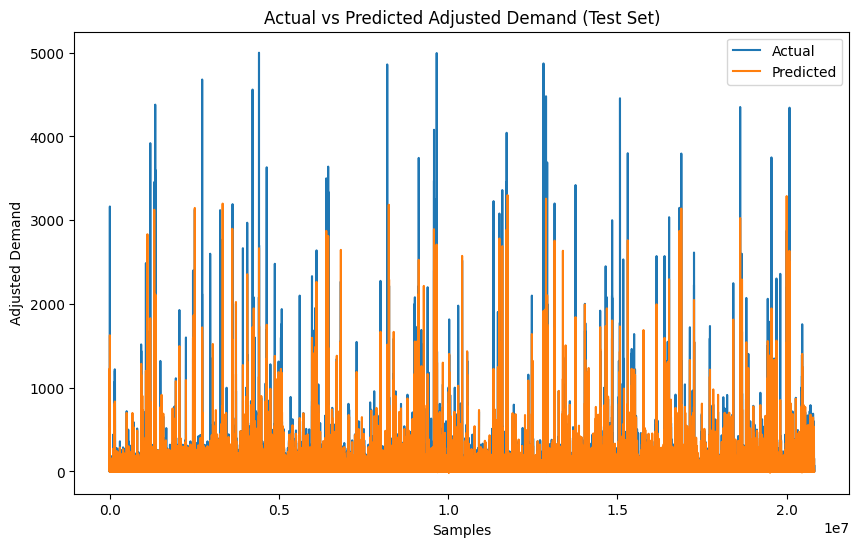

In [24]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')
 
# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Adjusted Demand (Test Set)')
plt.xlabel('Samples')
plt.ylabel('Adjusted Demand')
plt.legend()
plt.show()

In [25]:
del X_train
del y_train
del X_test
del y_test
del y_test_pred
gc.collect()

3655

In [26]:
# import xgboost as xgb
# kf = KFold(n_splits=5, shuffle=False)
# model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42)
# cv_scores = []

# for train_idx, val_idx in kf.split(X_train):
#     X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
#     y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
#     # Train the model
#     model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=10, verbose=False)
    
#     # Predict on the validation fold
#     y_val_pred = model.predict(X_val_fold)
    
#     # Evaluate the model
#     val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
#     cv_scores.append(val_rmse)

# print(f'Cross-Validation RMSE Scores: {cv_scores}')
# print(f'Average Cross-Validation RMSE: {np.mean(cv_scores)}')

# # Train the model on the full training set
# model.fit(X_train, y_train)

# # Predict on the test set
# y_test_pred = model.predict(X_test)

# # Evaluate the model on the test set
# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f'Test RMSE: {test_rmse}')
# print(f'Test R-squared: {test_r2}')

# # Plot actual vs predicted values for test set
# plt.figure(figsize=(10, 6))
# plt.plot(y_test.values, label='Actual')
# plt.plot(y_test_pred, label='Predicted')
# plt.title('Actual vs Predicted Adjusted Demand (Test Set)')
# plt.xlabel('Samples')
# plt.ylabel('Adjusted Demand')
# plt.legend()
# plt.show()

In [27]:
submission_df=pd.DataFrame()
test_df = pd.read_csv(test_file, compression='zip')
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
test_df.set_index('Week', inplace=True)
test_df = pd.concat([train_df[train_df.index>pd.to_datetime('2024-02-12')],test_df])
test_df = reduce_memory_usage(test_df)
test_df = lagged_feature_creation(test_df)
test_df = rolling_feature_creation(test_df,3)
gc.collect()
# test_df = pd.concat()
# submission_df['id']=test_df['id']
# test_df=test_df.drop('id',axis=1)

Memory usage of dataframe is 2549.97 MB
Memory usage after optimization is: 1420.70 MB
Decreased by 44.3%
Memory usage of dataframe is 1784.98 MB
Memory usage after optimization is: 1274.99 MB
Decreased by 28.6%


0

In [28]:
test_df = test_df.drop('Adjusted_Demand',axis=1)
test_df.head()

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3,Rolling_Mean_3,Rolling_Sum_3,Rolling_Std_3
Week,,,,,,,,,,,
2024-02-26,1110,7,3301,15766,1212,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-04,1110,7,3301,15766,1212,4.0,NaN,NaN,NaN,NaN,NaN
2024-02-19,1110,7,3301,15766,1216,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26,1110,7,3301,15766,1216,2.0,NaN,NaN,NaN,NaN,NaN
2024-03-18,1110,7,3301,15766,1216,5.0,2.0,NaN,NaN,NaN,NaN


In [29]:
test_df_first_week=test_df[test_df.index==pd.to_datetime('2024-03-11')]
y_test_pred = model.predict(test_df_first_week)
test_df_first_week['Adjusted_Demand']=y_test_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [30]:
test_df_first_week

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3,Rolling_Mean_3,Rolling_Sum_3,Rolling_Std_3,Adjusted_Demand
Week,,,,,,,,,,,,
2024-03-11,1110,7,3301,15766,1242,1.0,1.0,2.0,NaN,NaN,NaN,6.752112
2024-03-11,1110,7,3301,15766,1643,NaN,NaN,NaN,NaN,NaN,NaN,16.926123
2024-03-11,1110,7,3301,15766,3894,13.0,2.0,4.0,NaN,NaN,NaN,13.697061
2024-03-11,1110,7,3301,15766,32819,1.0,4.0,8.0,NaN,NaN,NaN,7.149187
2024-03-11,1110,7,3301,15766,32936,3.0,2.0,2.0,NaN,NaN,NaN,6.795814
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,25759,1,5517,4488100,32815,2.0,4.0,NaN,NaN,NaN,NaN,2.248693
2024-03-11,25759,1,5517,4488100,34226,1.0,NaN,NaN,NaN,NaN,NaN,2.445086
2024-03-11,25759,1,5517,4488107,40886,6.0,5.0,5.0,NaN,NaN,NaN,5.245486


In [31]:
test_df[test_df.index==pd.to_datetime('2024-03-18')].head()

,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Lagged_Demanda_1,Lagged_Demanda_2,Lagged_Demanda_3,Rolling_Mean_3,Rolling_Sum_3,Rolling_Std_3
Week,,,,,,,,,,,
2024-03-18,1110,7,3301,15766,1216,5.0,2.0,NaN,NaN,NaN,NaN
2024-03-18,1110,7,3301,15766,1240,2.0,2.0,8.0,NaN,NaN,NaN
2024-03-18,1110,7,3301,15766,5350,2.0,NaN,NaN,NaN,NaN,NaN
2024-03-18,1110,7,3301,15766,30531,17.0,17.0,13.0,NaN,NaN,NaN
2024-03-18,1110,7,3301,15766,32393,5.0,2.0,23.0,NaN,NaN,NaN


In [32]:
submission_df=pd.DataFrame()
test_df = pd.read_csv(test_file, compression='zip')
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
test_df.set_index('Week', inplace=True)
test_df_first_week= test_df_first_week[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]
test_df_1 = pd.concat([train_df[train_df.index>pd.to_datetime('2024-02-19')],test_df_first_week])
test_df = pd.concat([test_df_1,test_df[test_df.index==pd.to_datetime('2024-03-18')]])
test_df = reduce_memory_usage(test_df)
test_df = lagged_feature_creation(test_df)
test_df = rolling_feature_creation(test_df,3)
gc.collect()

Memory usage of dataframe is 2016.00 MB
Memory usage after optimization is: 1034.53 MB
Decreased by 48.7%
Memory usage of dataframe is 1299.79 MB
Memory usage after optimization is: 928.42 MB
Decreased by 28.6%


0

In [33]:
test_df_second_week=test_df[test_df.index==pd.to_datetime('2024-03-18')]

In [34]:
test_df_second_week = test_df_second_week.drop('Adjusted_Demand',axis=1)

In [35]:
y_test_pred = model.predict(test_df_second_week)
test_df_second_week['Adjusted_Demand']=y_test_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [36]:
submission = pd.concat([test_df_first_week,test_df_second_week])

In [37]:
submission = submission[['Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID','Adjusted_Demand']]

In [38]:
submission=submission.reset_index()

In [39]:
submission

,Week,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand
0,2024-03-11,1110,7,3301,15766,1242,6.752112
1,2024-03-11,1110,7,3301,15766,1643,16.926123
2,2024-03-11,1110,7,3301,15766,3894,13.697061
3,2024-03-11,1110,7,3301,15766,32819,7.149187
4,2024-03-11,1110,7,3301,15766,32936,6.795814
...,...,...,...,...,...,...,...
6999246,2024-03-18,25759,1,5517,4528866,35142,4.554208
6999247,2024-03-18,25759,1,5517,4565941,37581,4.857665
6999248,2024-03-18,25759,1,5517,4707699,34226,4.554208
6999249,2024-03-18,25759,1,5517,4707699,36598,4.643348


In [40]:
test_df = pd.read_csv(test_file, compression='zip')

In [41]:
test_df

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277
...,...,...,...,...,...,...,...
6999246,6999246,11,2057,1,1153,4379638,1232
6999247,6999247,10,1334,1,2008,970421,43069
6999248,6999248,11,1622,1,2869,192749,30532
6999249,6999249,11,1636,1,4401,286071,35107


In [42]:
test_df = test_df.rename({'Semana':'Week', 'Agencia_ID':'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID', 'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID',
       'Producto_ID':'Product_ID', 'Demanda_uni_equil':'Adjusted_Demand'},axis=1)
test_df['Week'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_df['Week'].astype(int) * 7, unit='D')
# test_df.set_index('Week', inplace=True)

In [43]:
test_df

,id,Week,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID
0,0,2024-03-18,4037,1,2209,4639078,35305
1,1,2024-03-18,2237,1,1226,4705135,1238
2,2,2024-03-11,2045,1,2831,4549769,32940
3,3,2024-03-18,1227,1,4448,4717855,43066
4,4,2024-03-18,1219,1,1130,966351,1277
...,...,...,...,...,...,...,...
6999246,6999246,2024-03-18,2057,1,1153,4379638,1232
6999247,6999247,2024-03-11,1334,1,2008,970421,43069
6999248,6999248,2024-03-18,1622,1,2869,192749,30532
6999249,6999249,2024-03-18,1636,1,4401,286071,35107


In [44]:
submission = submission.merge(test_df,on=['Week','Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID',
           'Product_ID'],how='inner')

In [45]:
submission

,Week,Sales_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Adjusted_Demand,id
0,2024-03-11,1110,7,3301,15766,1242,6.752112,6217476
1,2024-03-11,1110,7,3301,15766,1643,16.926123,4740450
2,2024-03-11,1110,7,3301,15766,3894,13.697061,970784
3,2024-03-11,1110,7,3301,15766,32819,7.149187,4230784
4,2024-03-11,1110,7,3301,15766,32936,6.795814,5433981
...,...,...,...,...,...,...,...,...
6999246,2024-03-18,25759,1,5517,4528866,35142,4.554208,806487
6999247,2024-03-18,25759,1,5517,4565941,37581,4.857665,5085000
6999248,2024-03-18,25759,1,5517,4707699,34226,4.554208,960441
6999249,2024-03-18,25759,1,5517,4707699,36598,4.643348,6414153


In [46]:
submission = submission[['id','Adjusted_Demand']]

In [47]:
submission=submission.sort_values(by='id')

In [48]:
submission_df['Demanda_uni_equil'] =y_test_pred

In [49]:
submission=submission.rename({'Adjusted_Demand':'Demanda_uni_equil'},axis=1)

In [50]:
submission.columns

Index(['id', 'Demanda_uni_equil'], dtype='object')

In [51]:
submission.to_csv('submission.csv',index=False)

In [52]:
submission_df = pd.read_csv('/kaggle/input/grupo-bimbo-inventory-demand/sample_submission.csv.zip', compression='zip')

In [53]:
submission_df

,id,Demanda_uni_equil
0,0,7
1,1,7
2,2,7
3,3,7
4,4,7
...,...,...
6999246,6999246,7
6999247,6999247,7
6999248,6999248,7
6999249,6999249,7


In [54]:
submission_df.to_csv('submission.csv',index=False)